In [3]:
# импортируемые библиотеки

# дефолтные мат. Библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# для разделения df на train и test выборку
from sklearn.model_selection import train_test_split

# для подготовки данных
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# перекрестная проверка модели
from sklearn.model_selection import cross_val_score

# модель
from sklearn.ensemble import RandomForestClassifier


# для стратифицированной выборки
from sklearn.model_selection import StratifiedKFold
# импортируем метрики
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, recall_score, roc_curve


# для нейронной сети
import torch
from torch.nn import Linear, Sigmoid

/Users/nascela/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# считывем датасет
df = pd.read_csv('audit_risk.csv')

In [5]:
# производим ручную подгонку данных
df = df.dropna (subset=['Risk'])
df = df.drop (index=[367, 355, 351])
df = df.astype({'LOCATION_ID': np.float})

/var/folders/4b/wpq4f85s0lzcrjpl4chzpqpw0000gn/T/ipykernel_22388/3051988053.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df = df.astype({'LOCATION_ID': np.float})


In [6]:
X = df.drop("Risk", axis = 1)
y = df["Risk"].copy()

In [7]:
# разделение выборки на тестовую и учебную
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
# делим выборки на ответы и признаки
X_train = train_set.drop("Risk", axis = 1)
y_train = train_set["Risk"].copy()

X_test = test_set.drop("Risk", axis = 1)
y_test = test_set["Risk"].copy()

X_full = df.drop("Risk", axis = 1)
y_full = df["Risk"].copy()

In [9]:
# обработка данных перед обучением

# вставка отсутсвующих значений и маштабирование

# создаем пайплайн для удобной и быстрой предобработки данных
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Категориальный нам не требуется, т.к. у нас только числовые признаки

# cat_pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy="most_frequent")),
#     ("cat_encoder", OneHotEncoder(sparse=False)),
# ])

num_attribs = list(X)
# cat_attribs = [""]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs)
    # ("cat", cat_pipeline, cat_attribs),
])

X_train_prepared = preprocess_pipeline.fit_transform(X_train[num_attribs])
X_test_prepared = preprocess_pipeline.fit_transform(X_test[num_attribs])
X_full_prepared = preprocess_pipeline.fit_transform(X_full[num_attribs])

In [10]:
#разбиваем наше множество на 5 частей и перемешиваем "shuffle=True"(Стратифицированная выборка)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

forest_clf = RandomForestClassifier(n_estimators = 100, random_state=42)
forest_clf.fit(X_train_prepared, y_train)


In [11]:
# получаем значение метрики с помощью перекрестной проверки - roc auc целевая
forest_scores = cross_val_score(forest_clf, X_train_prepared, y_train, cv = cv, scoring="roc_auc")
forest_scores.mean()

1.0

In [49]:
# получаем значение метрики с помощью стандартной проверки(fit - predict) - roc auc целевая
pred = forest_clf.predict(X_test_prepared)
print('precision', precision_score(y_test, pred))   #рассчитаем метрики
print('recall', recall_score(y_test, pred))
print('accuracy', accuracy_score(y_test, pred))
print('f1', f1_score(y_test, pred))

precision 1.0
recall 0.9310344827586207
accuracy 0.9741935483870968
f1 0.9642857142857143


(-0.01, 1.01)

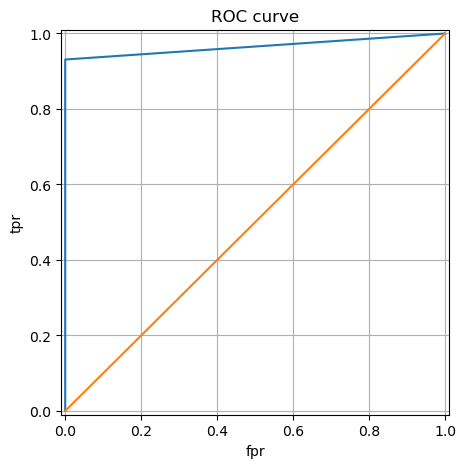

In [13]:
# график roc auc score
%matplotlib inline
fpr, tpr, thresholds = roc_curve(y_test, pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

In [14]:
# модель случайного леса умеет рассчитывать вероятность
predict_proba = forest_clf.predict_proba(X_test_prepared)

(-0.01, 1.01)

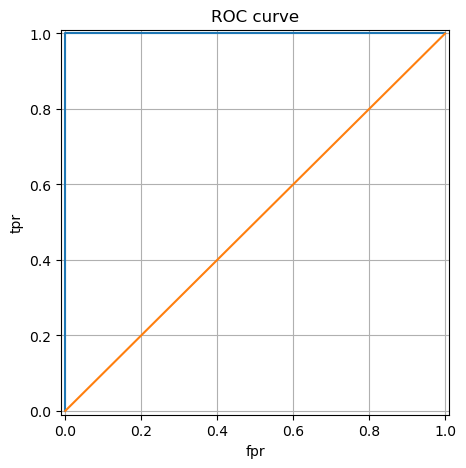

In [15]:
# график roc auc score для наилучшего результата
%matplotlib inline
fpr, tpr, thresholds = roc_curve(y_test, predict_proba[:,1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

In [16]:
roc_auc_score(y_test, predict_proba[:,1]) #значение метрики ROC AUC

1.0

In [17]:
# построим модель машинного обучения на основе нейронных сетей

num_features = X_train_prepared.shape[1]

# зададим 1 нейрон

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [18]:
neuron

Sequential(
  (0): Linear(in_features=26, out_features=1, bias=True)
  (1): Sigmoid()
)

In [23]:
# преобразуем данные в тензоры
X_train_tensor = torch.autograd.Variable(torch.FloatTensor(X_train_prepared))
y_train_tensor = torch.autograd.Variable(torch.FloatTensor(y_train.values.reshape((-1, 1))))

X_test_tensor = torch.autograd.Variable(torch.FloatTensor(X_test_prepared))
y_test_tensor = torch.autograd.Variable(torch.FloatTensor(y_test.values.reshape((-1, 1))))


In [26]:
# квадратичная функция потерь
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска
learning_rate = 0.001
# сам метод оптимизации нейросети
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети
    y_pred = neuron(X_train_tensor)

    # выведем loss
    loss = loss_fn(y_pred, y_train_tensor)
    print('{} {}'.format(t, loss.data))

    # обнуляем градиенты перед backard_pass'ом
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # этой командой мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # а тут уже обновляем веса
    optimizer.step()

0 172.69036865234375
1 101.72531127929688
2 75.61978912353516
3 62.84288787841797
4 55.07097244262695
5 49.77729797363281
6 45.90683364868164
7 42.9342041015625
8 40.566959381103516
9 38.62892150878906
10 37.00734329223633
11 35.62651062011719
12 34.43354034423828
13 33.39028549194336
14 32.468482971191406
15 31.646703720092773
16 30.908388137817383
17 30.24051856994629
18 29.632701873779297
19 29.076547622680664
20 28.565196990966797
21 28.092979431152344
22 27.655162811279297
23 27.247787475585938
24 26.86746597290039
25 26.51133918762207
26 26.176931381225586
27 25.86211395263672
28 25.56502342224121
29 25.284046173095703
30 25.01775550842285
31 24.764904022216797
32 24.524375915527344
33 24.29519271850586
34 24.076461791992188
35 23.867406845092773
36 23.66731071472168
37 23.475543975830078
38 23.291526794433594
39 23.114730834960938
40 22.944690704345703
41 22.78097152709961
42 22.62317657470703
43 22.470947265625
44 22.323951721191406
45 22.181888580322266
46 22.044475555419922
4

/Users/nascela/anaconda3/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [27]:
# проверяем нейронную сеть, предсказывем значения
proba_pred = neuron(X_test_tensor)
y_pred = proba_pred > 0.5

In [36]:
# выводим метрики
print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))
print('accuracy', accuracy_score(y_test, y_pred))
print('f1', f1_score(y_test, y_pred))
print('roc auc', roc_auc_score(y_test, y_pred)) # целевая

precision 0.9661016949152542
recall 0.9827586206896551
accuracy 0.9806451612903225
f1 0.9743589743589743
roc auc 0.9810700319943121


(-0.01, 1.01)

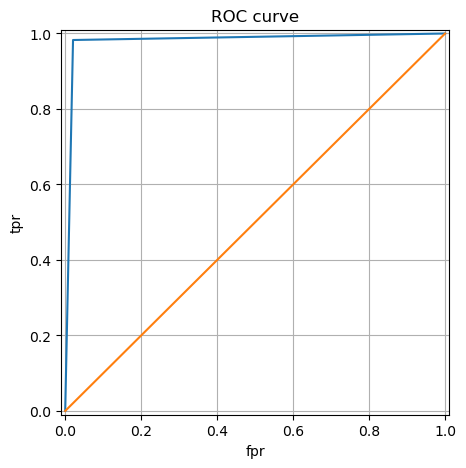

In [37]:
# график roc auc score для нейронной сети
%matplotlib inline
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))